# Comparing Machine Learning Techniques Using Pipelines - Lab

## Introduction

In this lab, you'lll use a Dataset created by Otto group, which was also used in a [Kaggle competition](https://www.kaggle.com/c/otto-group-product-classification-challenge/data).

The description of the data set is as follows:

The Otto Group is one of the world’s biggest e-commerce companies, with subsidiaries in more than 20 countries, including Crate & Barrel (USA), Otto.de (Germany) and 3 Suisses (France). They are selling millions of products worldwide every day, with several thousand products being added to our product line.

A consistent analysis of the performance of our products is crucial. However, due to their global infrastructure, many identical products get classified differently. Therefore, the quality of our product analysis depends heavily on the ability to accurately cluster similar products. The better the classification, the more insights Otto Group can generate about their product range.

In this lab, you'll use a data set containing:
- A column `id`, which is an anonymous id unique to a product
- 93 columns `feat_1`, `feat_2`, ..., `feat_93`, which are the various features of a product
- a column `target` - the class of a product


## Objectives

You will be able to:
- Compare different classification techniques
- Construct pipelines in scikit-learn
- Use pipelines in combination with GridSearchCV

## The Data Science Workflow

You will be following the data science workflow:

1. Initial data inspection, exploratory data analysis, and cleaning
2. Feature engineering and selection
3. create a baseline model
4. create a machine learning pipeline and compare results with the baseline model
5. Interpret the model and draw conclusions

##  Initial data inspection, exploratory data analysis, and cleaning

The data is stored in "otto_group.csv".

Things to do here:
- Check for NAs
- Check the distributions
- Check how many inputs there are
- ...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_df = pd.read_csv('otto_group.csv')
raw_df.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [3]:
raw_df.isna().any().any()

False

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 95 columns):
id         61878 non-null int64
feat_1     61878 non-null int64
feat_2     61878 non-null int64
feat_3     61878 non-null int64
feat_4     61878 non-null int64
feat_5     61878 non-null int64
feat_6     61878 non-null int64
feat_7     61878 non-null int64
feat_8     61878 non-null int64
feat_9     61878 non-null int64
feat_10    61878 non-null int64
feat_11    61878 non-null int64
feat_12    61878 non-null int64
feat_13    61878 non-null int64
feat_14    61878 non-null int64
feat_15    61878 non-null int64
feat_16    61878 non-null int64
feat_17    61878 non-null int64
feat_18    61878 non-null int64
feat_19    61878 non-null int64
feat_20    61878 non-null int64
feat_21    61878 non-null int64
feat_22    61878 non-null int64
feat_23    61878 non-null int64
feat_24    61878 non-null int64
feat_25    61878 non-null int64
feat_26    61878 non-null int64
feat_27    61878 non-null i

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc45975fa20>,
      dtype=object)

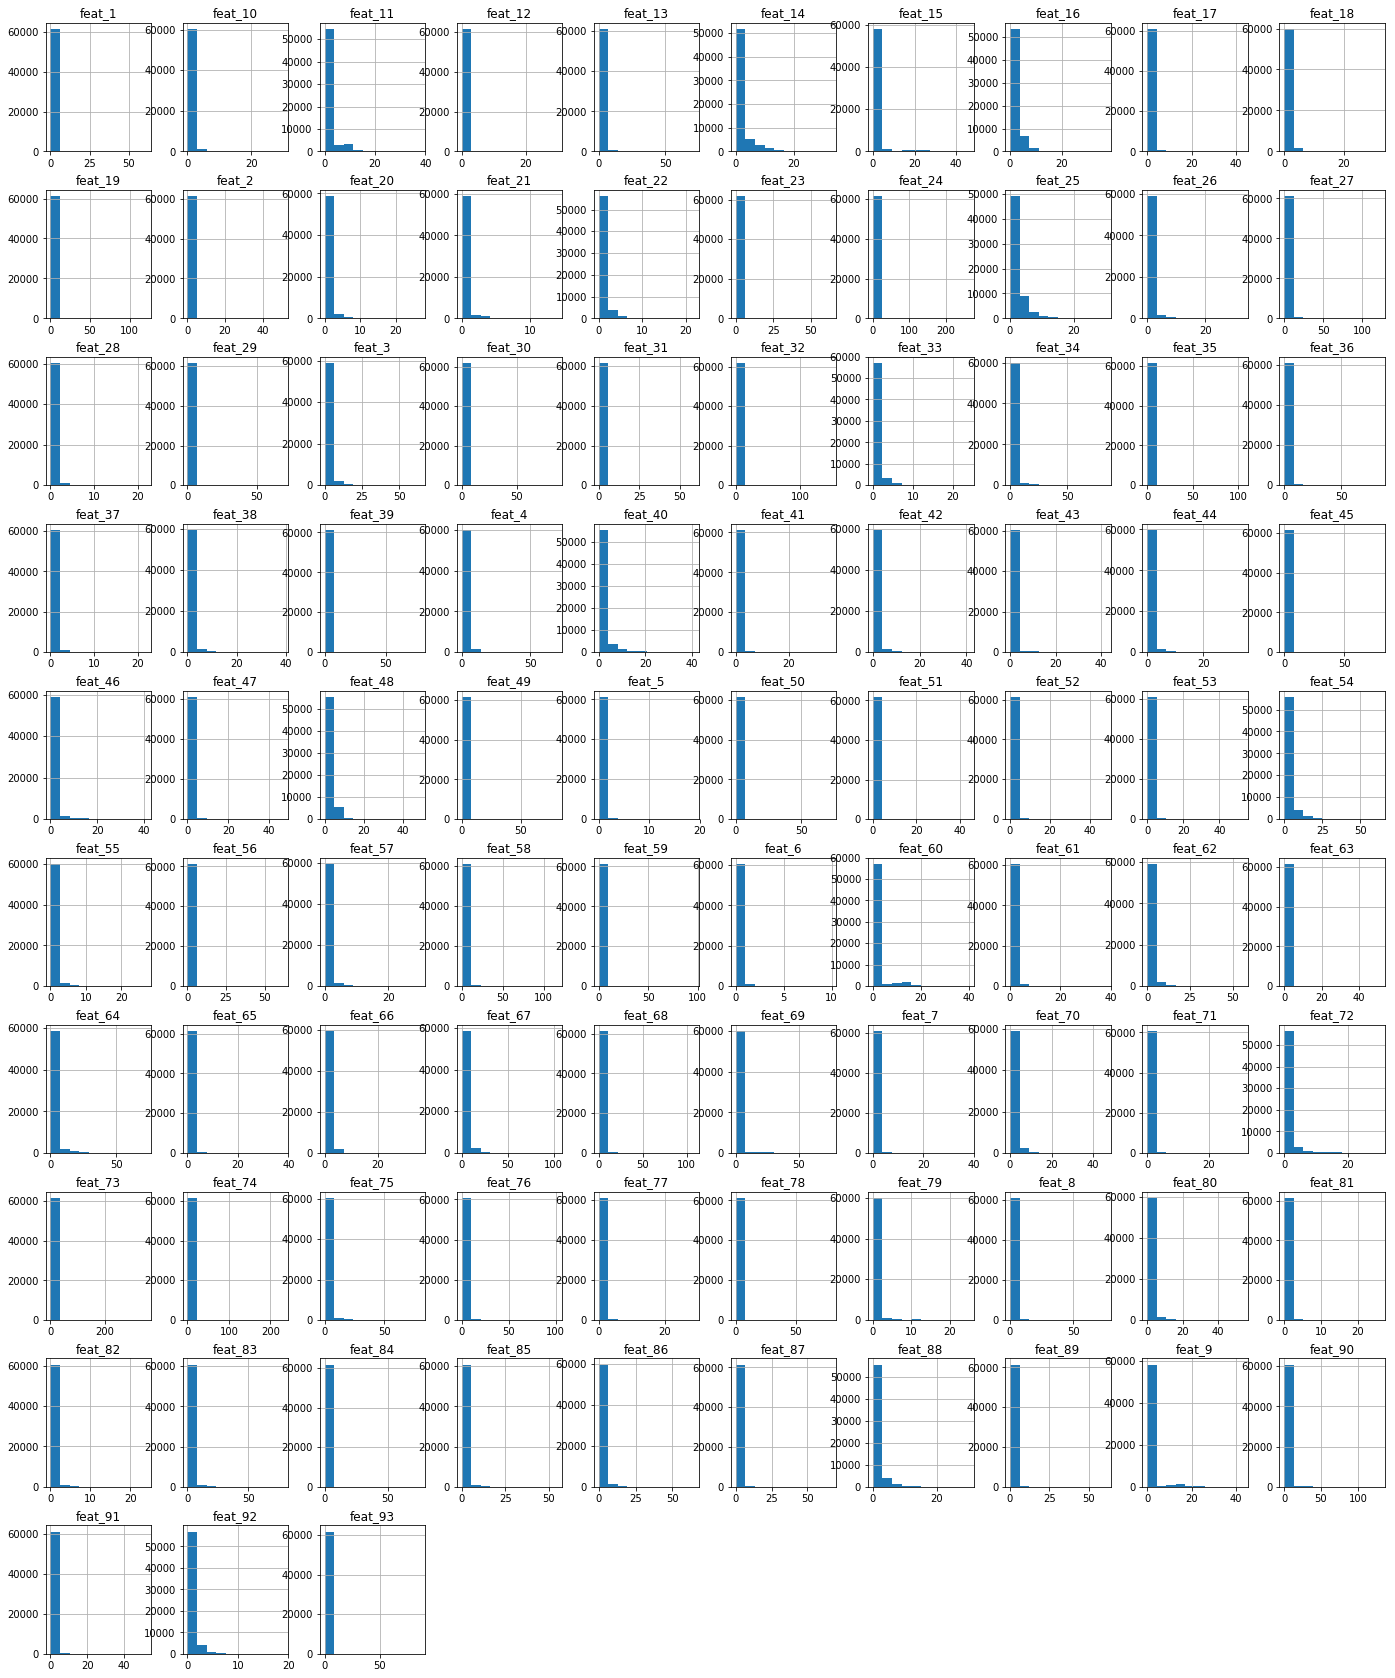

In [5]:
df = raw_df.drop(['id', 'target'], axis=1)
target = raw_df.target

df.hist(figsize=(24,30))

If you look at all the histograms, you can tell that a lot of the data are zero-inflated, so most of the variables contain mostly zeros and then some higher values here and there. No normality, but for most machine learning techniques this is not an issue. 

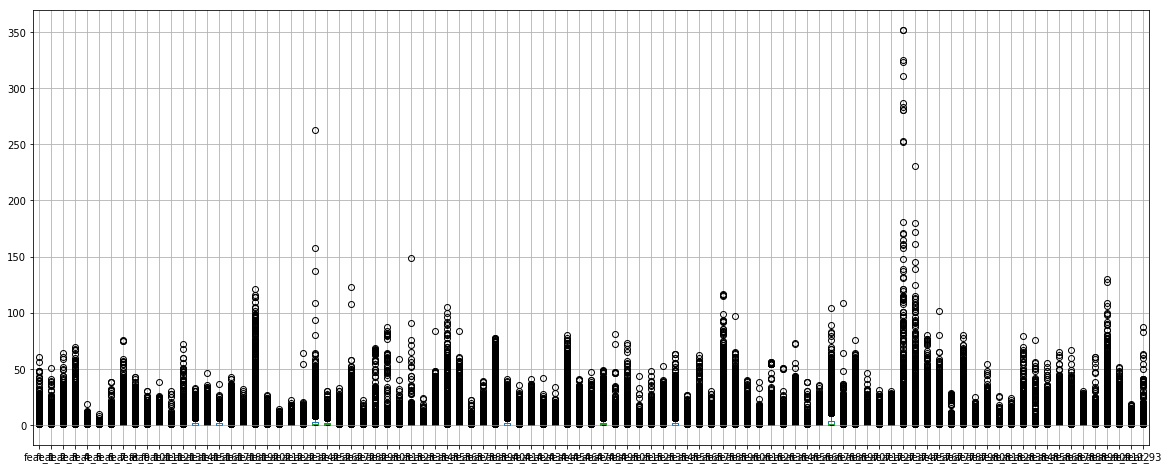

In [6]:
df.boxplot(figsize = (20,8))

Because the data is zero-inflated the boxplots look as shown above. Because there are this many zeroes, most values above zero will seem to be outliers. The safe decision for this data is to not delete any outliers and see what happens. With many 0s, sparse data is available and high values may be super informative. More-over, without having any intuitive meaning for each of the features, we don't know if a value of ~260 is actually an outlier.

## Feature engineering and selection with PCA

Have a look at the correlation structure of your features using a heatmap.

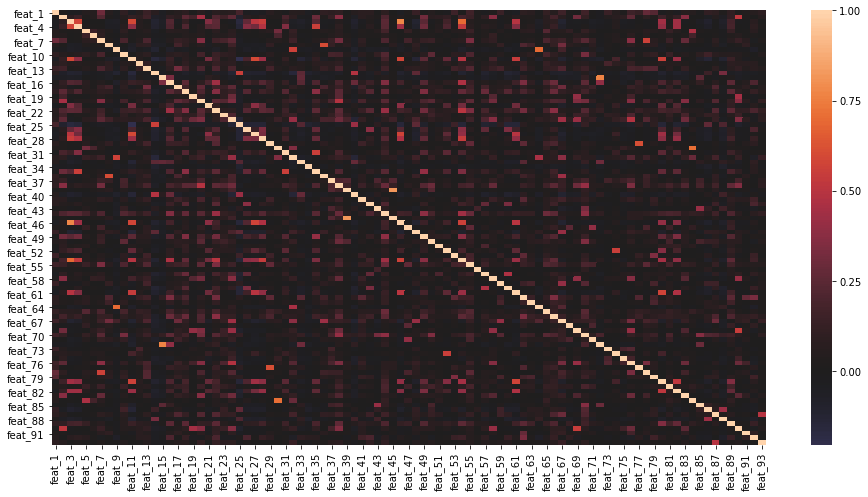

In [7]:
import seaborn as sns
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), center=0)

Use PCA to downscale your features. Use PCA to select a number of features in a way that you still keep 80% of your explained variance.

In [8]:
from sklearn.decomposition import PCA
components = list(range(20,30))
for n in components:
    pca = PCA(n_components=int(n))
    principle_components = pca.fit_transform(df)
    var = np.sum(pca.explained_variance_ratio_)
    if var > .79:
        print('{} components, {} variance explained'.format(n, round(var, 2)))

26 components, 0.79 variance explained
27 components, 0.8 variance explained
28 components, 0.81 variance explained
29 components, 0.82 variance explained


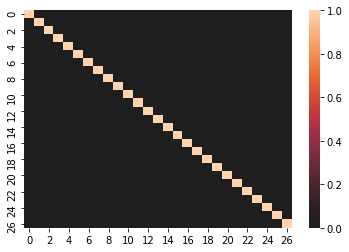

In [9]:
pca = PCA(n_components=27)
pcadf = pd.DataFrame(pca.fit_transform(df))
sns.heatmap(pcadf.corr(), center=0)

## Create a train test split with a test size of 40%

This is a relatively big training set. Feel free to make it smaller (down to ~20%), but for an initial run you can try smaller training sets so the computation time is more manageable.

For now, simply use the original data and not the principal components. We looked at the PC's first to get a sense of our correlation structure, and to see how we can downsize our data without losing too much information. In what's next, you'll make PCA part of the pipeline!!

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=.40, random_state=42)

## Create a baseline model

Create your baseline model *in a pipeline setting*. In the pipeline
- Your first step will be to scale your features down to the number of features that ensure you keep just 80% of your explained variance (which we saw before)
- Your second step will be the building a basic logistic regression model.

Make sure to fit the model using the training set, and test the result by obtaining the accuracy using the test set.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [13]:
pipe = Pipeline([('pca', PCA(n_components=27, random_state=123)), ('clf', LogisticRegression(random_state=123))])
pipe.fit(X_train, y_train)

/Users/rlathbury/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rlathbury/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=27,
                     random_state=123, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=123,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [14]:
pipe.score(X_test, y_test)

0.7171541693600517

## Create a pipeline consisting of a linear SVM, a simple Decision Tree and a simple Random Forest Classifier

Repeat the above, but now create three different pipelines:
- One for a standard linear SCM
- One for a default decision tree
- One for a RandomForestClassifier

In [15]:
# ⏰ This cell may take several minutes to run
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_svc = Pipeline([('pca', PCA(n_components=27, random_state=123)), 
                     ('svc', SVC(random_state=123))])
pipe_rfc = Pipeline([('pca', PCA(n_components=27, random_state=123)), 
                     ('clf', RandomForestClassifier(random_state=123))])
pipe_dec_tree = Pipeline([('pca', PCA(n_components=27, random_state=123)), 
                          ('clf', DecisionTreeClassifier(random_state=123))])

names = ['SVC', 'Random Forest', 'Decision Tree']
pipes = [pipe_svc, pipe_rfc, pipe_dec_tree]
for i, pipe in enumerate(pipes):
    pipe.fit(X_train, y_train)
    print(names[i], round(pipe.score(X_test, y_test), 3))

/Users/rlathbury/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.748


/Users/rlathbury/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest 0.746
Decision Tree 0.671


## Pipeline with grid search

Construct two pipelines with grid search:
- one for random forests - try to have around 40 different models
- one for the adaboost algorithm 

As extra, level-up work, construct a pipeline with grid search for support vector machines. 
* Make sure your grid isn't too big. You'll see it takes quite a while to fit SVMs with non-linear kernel functions!

### Random Forest pipeline with grid search

In [16]:
# imports
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [17]:
# ⏰ This cell may take a long time to run!
pipe_rf = Pipeline([('pca', PCA(n_components=27, random_state=123)),
                   ('clf', RandomForestClassifier(random_state=123))])
grid_params = {'clf__max_depth': [4, 5, 6],
              'clf__n_estimators': [120],
              'clf__criterion': ['entropy', 'gini'],
              'clf__min_samples_split': [.05, .1, .2],
              'clf__min_samples_leaf': [.05, .1, .2]}

gridsearch = GridSearchCV(pipe_rf, grid_params, scoring='accuracy', cv=3, verbose=2)
gridsearch.fit(X_train, y_train)
print("Best Parameters: {}\nBest Accuracy: {}".format(gridsearch.best_params_, gridsearch.best_score_))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=  16.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.2s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=  15.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=  14.7s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=  13.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=  18.7s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=  13.9s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=  11.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=  12.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=  11.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   7.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   7.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   7.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   7.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samp

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   4.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   4.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   4.0s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   4.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   2.7s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   2.7s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   2.7s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   2.7s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sam

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   2.7s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   2.7s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   2.7s


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 16.7min finished


Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 120}
Best Accuracy: 0.6222593330819371


Use your grid search object along with `.cv_results` to get the full result overview

In [18]:
gridsearch.cv_results_

{'mean_fit_time': array([15.17716495, 16.48310224, 10.00817728,  7.40689063,  7.93223333,
         9.18460814,  3.62875366,  3.50928394,  3.46853407, 11.74579565,
        12.69951955, 11.2783637 ,  9.36089198,  9.27043287,  7.96725464,
         3.71487228,  3.69595337,  4.69037882, 13.55110129, 11.95168662,
        10.29592403,  7.25498398,  7.30776381,  7.3235143 ,  3.47889972,
         3.47539441,  4.59021568,  5.27203512,  4.95169099,  4.34898265,
         3.84706354,  3.85906005,  3.82581862,  2.52804756,  2.5232114 ,
         2.50699059,  5.24819469,  5.28604921,  4.46121335,  3.83236512,
         3.81935557,  3.87919362,  2.50504724,  2.49832082,  2.50822512,
         5.37988798,  5.39517291,  4.51483258,  3.830235  ,  3.86989403,
         3.84087753,  2.5770309 ,  2.53756142,  2.50743032]),
 'std_fit_time': array([0.55375576, 2.34043972, 0.03183265, 0.20193612, 0.05060605,
        1.9364215 , 0.20845422, 0.03642749, 0.03307286, 0.19646644,
        0.89307852, 0.39886869, 1.21659

### Adaboost

In [19]:
# ⏰ This cell may take several minutes to run
pipe_ada = Pipeline([('pca', PCA(n_components=27, random_state=123)),
                    ('clf', AdaBoostClassifier(random_state=123))])

grid_params_ada = {'clf__n_estimators': [30, 50, 70],
              'clf__learning_rate': [1, .5, .1]}

gridsearch_ada = GridSearchCV(pipe_ada, grid_params_ada, scoring='accuracy', cv=3, verbose=2)
gridsearch_ada.fit(X_train, y_train)

print("Best Parameters: {}\nBest Accuracy: {}".format(gridsearch_ada.best_params_, gridsearch_ada.best_score_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__learning_rate=1, clf__n_estimators=30 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... clf__learning_rate=1, clf__n_estimators=30, total=   5.9s
[CV] clf__learning_rate=1, clf__n_estimators=30 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] ....... clf__learning_rate=1, clf__n_estimators=30, total=   5.9s
[CV] clf__learning_rate=1, clf__n_estimators=30 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=30, total=   5.9s
[CV] clf__learning_rate=1, clf__n_estimators=50 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=50, total=   9.4s
[CV] clf__learning_rate=1, clf__n_estimators=50 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=50, total=   9.5s
[CV] clf__learning_rate=1, clf__n_estimators=50 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=50, total=   9.4s
[CV] clf__learning_rate=1, clf__n_estimators=70 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=70, total=  13.0s
[CV] clf__learning_rate=1, clf__n_estimators=70 ......................
[CV] ....... clf__learning_rate=1, clf__n_estimators=70, total=  13.0s
[CV] clf__learning_rate=1, clf__n_estimators=70 ......................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  4.3min finished


Best Parameters: {'clf__learning_rate': 0.5, 'clf__n_estimators': 50}
Best Accuracy: 0.662285190971287


Use your grid search object along with `.cv_results` to get the full result overview

In [20]:
gridsearch.cv_results_

{'mean_fit_time': array([15.17716495, 16.48310224, 10.00817728,  7.40689063,  7.93223333,
         9.18460814,  3.62875366,  3.50928394,  3.46853407, 11.74579565,
        12.69951955, 11.2783637 ,  9.36089198,  9.27043287,  7.96725464,
         3.71487228,  3.69595337,  4.69037882, 13.55110129, 11.95168662,
        10.29592403,  7.25498398,  7.30776381,  7.3235143 ,  3.47889972,
         3.47539441,  4.59021568,  5.27203512,  4.95169099,  4.34898265,
         3.84706354,  3.85906005,  3.82581862,  2.52804756,  2.5232114 ,
         2.50699059,  5.24819469,  5.28604921,  4.46121335,  3.83236512,
         3.81935557,  3.87919362,  2.50504724,  2.49832082,  2.50822512,
         5.37988798,  5.39517291,  4.51483258,  3.830235  ,  3.86989403,
         3.84087753,  2.5770309 ,  2.53756142,  2.50743032]),
 'std_fit_time': array([0.55375576, 2.34043972, 0.03183265, 0.20193612, 0.05060605,
        1.9364215 , 0.20845422, 0.03642749, 0.03307286, 0.19646644,
        0.89307852, 0.39886869, 1.21659

### Level-up: SVM pipeline with grid search

In [23]:
# ⏰ This cell may take a very long time to run!
pipe_svc = Pipeline([('pca', PCA(n_components=27, random_state=123)),
                    ('clf', SVC(random_state=123))])

grid_params_svc = {'clf__C': [.1, 1, 10],
                  'clf__gamma': [.001, .01],
                  'clf__kernel': ['linear', 'rbf']}

gridsearch_svc = GridSearchCV(pipe_svc, grid_params_svc, scoring='accuracy', cv=3, verbose=2)
gridsearch_svc.fit(X_train, y_train)

print("Best Parameters: {}\nBest Accuracy: {}".format(gridsearch_svc.best_params_, gridsearch_svc.best_score_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=  33.5s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.6s remaining:    0.0s


[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=  32.7s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=  32.5s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=  42.9s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=  42.4s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=  42.6s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=linear .................
[CV] .. clf__C=0.1, clf__gamma=0.01, clf__kernel=linear, total=  32.8s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=linear .................
[CV] .. clf__C=0.1, clf__gamma=0.01, clf__kernel=linear, total=  32.5s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=linear .................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 150.7min finished


Best Parameters: {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Best Accuracy: 0.7676560900716479


Use your grid search object along with `.cv_results` to get the full result overview

In [24]:
gridsearch_svc.cv_results_

{'mean_fit_time': array([  27.64246806,   32.32771802,   27.44305333,   35.90633869,
         113.10832461,   22.31851347,  121.98477864,   47.01633191,
        1230.79078873,   20.06689254, 1209.22243786,   31.21289158]),
 'std_fit_time': array([4.37246459e-01, 1.96939243e-01, 1.31072255e-01, 5.35467874e-01,
        4.60552321e+01, 7.22025567e-02, 4.21727999e+01, 5.79605958e-01,
        3.31205212e+02, 3.85555437e-01, 3.34324409e+02, 7.33274249e-01]),
 'mean_score_time': array([ 5.25843175, 10.30841597,  5.28750197, 10.45099545,  5.1725049 ,
         8.89586115,  6.332774  , 14.00339214,  5.50156633,  8.24213529,
         5.14964739,  9.40252606]),
 'std_score_time': array([0.025897  , 0.06050167, 0.16351196, 0.0542673 , 0.06147029,
        0.00698208, 1.47819851, 0.26050237, 0.28087421, 0.0669499 ,
        0.01854456, 0.0424027 ]),
 'param_clf__C': masked_array(data=[0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, 

## Note

Note that this solution is only one of many options. The results in the Random Forest and Adaboost models show that there is a lot of improvement possible tuning the hyperparameters further, so make sure to explore this yourself!

## Summary 

Great! You now got a lot of practice in. What algorithm would you choose and why?